In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
module = fc.eightb.preselection.t8btag_minmass
dout = "gen_mp"

In [4]:
altfile = 'gen_mp_{base}'
use_signal = [ module.full_signal_list.index(f) for f in module.signal_list ]
# signal = ObjIter([Tree(f, altfile=altfile, report=False) for f in tqdm(module.full_signal_list)])
signal = ObjIter([Tree(f, altfile=altfile, report=False) for f in tqdm(module.signal_list)])
bkg = ObjIter([Tree(module.Run2_UL18.QCD_B_List, altfile=altfile), Tree(module.Run2_UL18.TTJets, altfile=altfile)])
# data = ObjIter([ Tree(module.Run2_UL18.JetHT_Data_UL_List, altfile=altfile) ])


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


In [8]:
analysis = eightb.TestAnalysis(
    signal=signal, bkg=bkg,
    
)

In [7]:
analysis.reweight_bkg()

In [10]:
analysis.jet_kin_pt_cuts()

In [11]:
signal, bkg = analysis.signal, analysis.bkg

In [24]:
def ordered_btag(t):
    t.extend(
        ordered_jet_btag = ak.sort(t.jet_btag, axis=-1, ascending=False)
    )
(signal+bkg).apply(ordered_btag)

[None, None, None, None, None]

100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


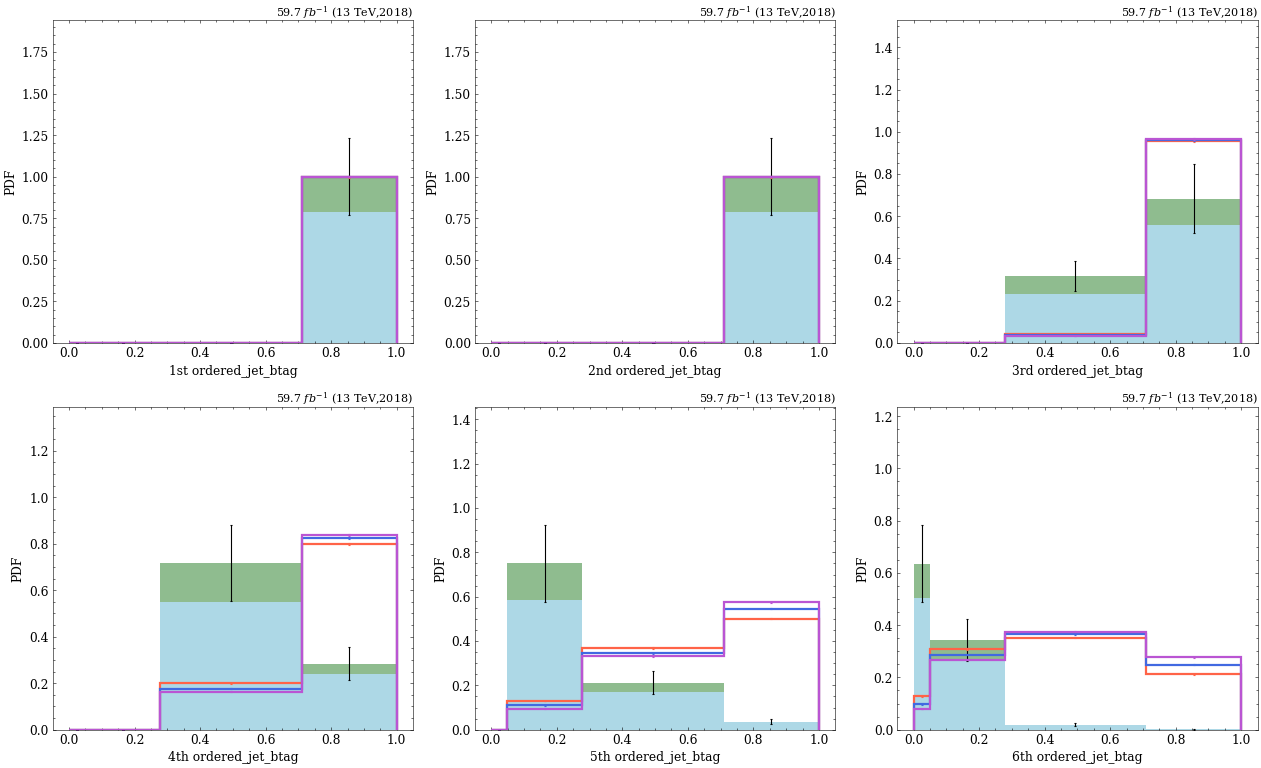

In [39]:
study.quick( 
    signal+bkg,
    # plot_scale=[100]*len(signal),
    efficiency=True,
    masks=event_filter.filters[0],
    varlist=[f'ordered_jet_btag[:,{i}]' for i in range(6)],
    binlist=[np.array(jet_btagWP)]*6,
)

In [78]:
def resonance_max_btag(t):
    h_j1_btag = t.jet_btag[t.higgs_j1Idx]
    h_j2_btag = t.jet_btag[t.higgs_j2Idx]
    higgs_max_btag = ak.where( h_j1_btag > h_j2_btag, h_j1_btag, h_j2_btag )
    higgs_min_btag = ak.where( h_j1_btag < h_j2_btag, h_j1_btag, h_j2_btag )

    def y_extrema_btag(h1Idx, h2Idx):
        h1Idx = ak.from_regular(h1Idx[:,None])
        h2Idx = ak.from_regular(h2Idx[:,None])

        h1_max_btag = higgs_max_btag[h1Idx][:,0]
        h2_max_btag = higgs_max_btag[h2Idx][:,0]
        
        h1_min_btag = higgs_min_btag[h1Idx][:,0]
        h2_min_btag = higgs_min_btag[h2Idx][:,0]

        y_max_btag = ak.where( h1_max_btag > h2_max_btag, h1_max_btag, h2_max_btag )
        y_min_btag = ak.where( h1_min_btag < h2_min_btag, h1_min_btag, h2_min_btag )
        return y_max_btag, y_min_btag

    y1_max_btag, y1_min_btag = y_extrema_btag(t.Y1_h1Idx, t.Y1_h2Idx)
    y2_max_btag, y2_min_btag = y_extrema_btag(t.Y2_h1Idx, t.Y2_h2Idx)

    t.extend(
        higgs_max_btag=higgs_max_btag, 
        higgs_min_btag=higgs_min_btag,
        Y1_max_btag=y1_max_btag,
        Y1_min_btag=y1_min_btag,
        Y2_max_btag=y2_max_btag,
        Y2_min_btag=y2_min_btag,
        )
(signal+bkg).apply(resonance_max_btag)

[None, None, None, None, None]

100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


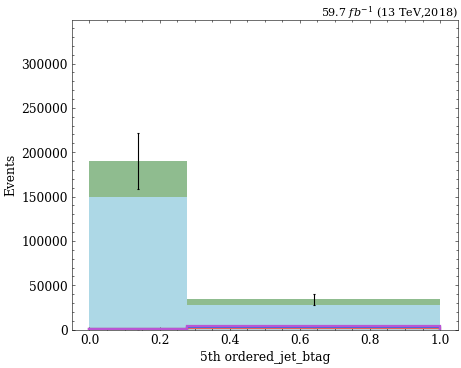

In [129]:
event_filter = eightb.selected_jet_btagwp([3, 3, 2, 2, 0])
study.quick( 
    signal+bkg, 
    masks=event_filter.filters[0],
    varlist=['ordered_jet_btag[:,4]'],
    # binlist=[np.array(jet_btagWP)],
    binlist=[np.array([0, jet_btagWP[2], 1])],
    # efficiency=True,
)

100%|██████████| 2/2 [00:04<00:00,  2.29s/it]


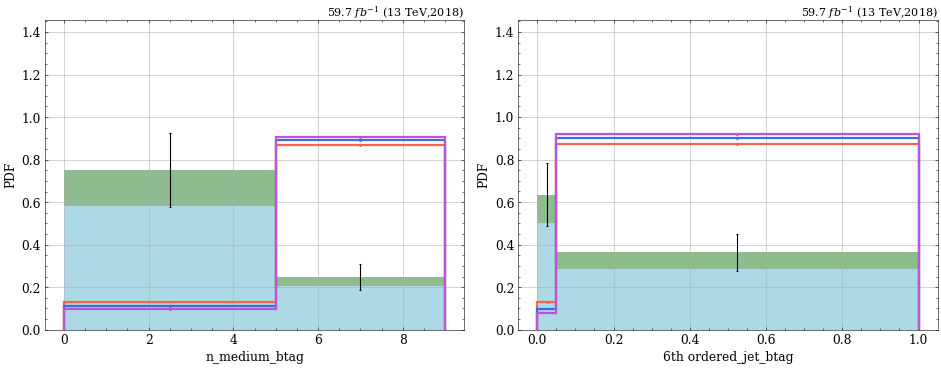

In [136]:
event_filter = eightb.selected_jet_btagwp([3, 3, 2, 2, 1])
study.quick( 
    signal+bkg, 
    masks=event_filter.filters[0],
    varlist=['n_medium_btag', 'ordered_jet_btag[:,5]'],
    # binlist=[np.array(jet_btagWP)],
    binlist=[np.array([0, 5, 9])]+[np.array([0, jet_btagWP[1], 1])],
    grid=True,
    efficiency=True,
)

In [139]:
analysis.__dict__.update(
    ar_center=[125,125],
    vr_center=[210,210],
    sr_r=50, cr_r=70
)

analysis.build_higgs_dm()

100%|██████████| 1/1 [00:04<00:00,  4.15s/it]


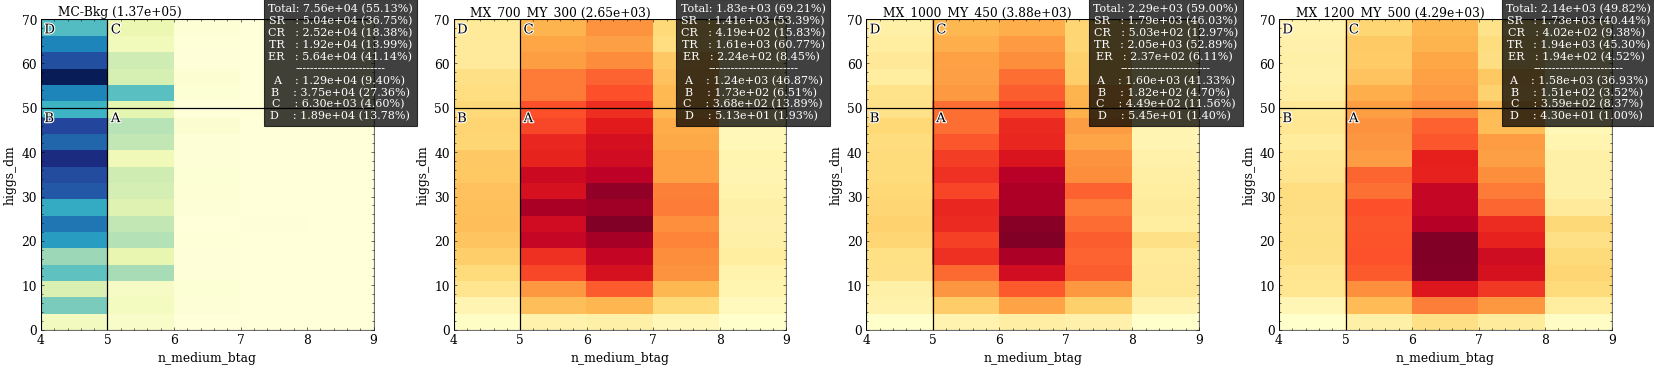

In [151]:
study.quick2d( 
    signal+bkg,
    masks=event_filter.filters[0],
    varlist=['n_medium_btag','higgs_dm'],
    binlist=[np.arange(4,10),(0, analysis.cr_r, 20)],
    exe=draw_abcd(x_r=(4,5,9), y_r=(0, analysis.sr_r, analysis.cr_r), regions=["C","D","A","B"]),
)

100%|██████████| 1/1 [00:04<00:00,  4.24s/it]


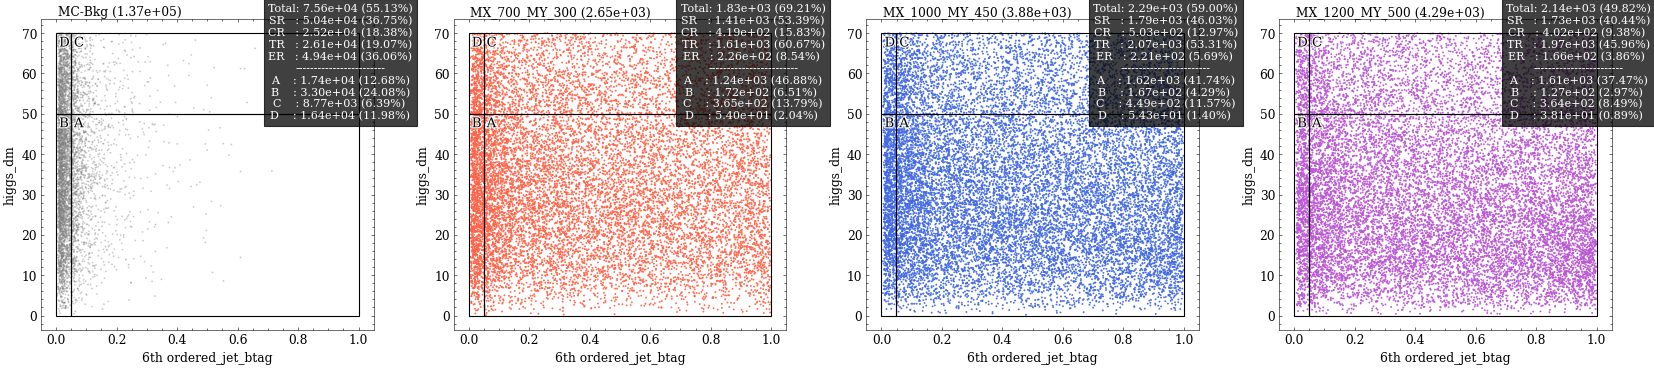

In [164]:
study.quick2d( 
    signal+bkg,
    masks=event_filter.filters[0],
    varlist=['ordered_jet_btag[:,5]','higgs_dm'],
    binlist=[(0,1,20),(0, analysis.cr_r, 20)],
    scatter=True,
    exe=draw_abcd(x_r=[0, jet_btagWP[1], 1], y_r=(0, analysis.sr_r, analysis.cr_r), regions=["C","D","A","B"]),
)

100%|██████████| 1/1 [00:04<00:00,  4.21s/it]


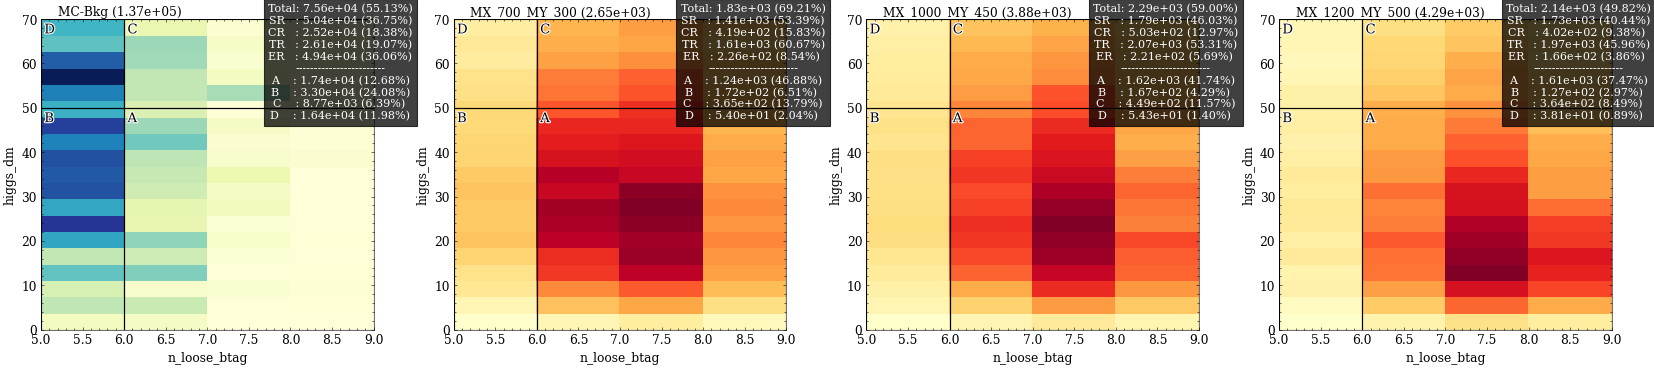

In [166]:
study.quick2d( 
    signal+bkg,
    masks=event_filter.filters[0],
    varlist=['n_loose_btag','higgs_dm'],
    binlist=[np.arange(5,10),(0, analysis.cr_r, 20)],
    exe=draw_abcd(x_r=[5,6,9], y_r=(0, analysis.sr_r, analysis.cr_r), regions=["C","D","A","B"]),
)